In [ ]:
#Hardware real de IBM ibm_brisbane 13/02/2025

In [7]:
import qiskit
print(qiskit.__version__)

1.3.2


In [2]:
from qiskit import QuantumCircuit
from qiskit import qasm3
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit.visualization import plot_histogram
import pandas as pd  
import numpy as np   

# Definir el grafo del problema Max-Cut
edges = {(0, 1): 1, (1, 2): 1, (2, 3): 1, (0, 3): 1}
num_nodes = 4
num_shots=4046

# Función para generar el circuito QAOA
def generate_QAOA(edges, beta, gamma):
    assert len(beta) == len(gamma), "Gamma y Beta no tienen la misma longitud"

    num_levels = len(beta)
    circ = QuantumCircuit(num_nodes)
    circ.h(range(num_nodes)) 

    for level in range(num_levels):
        # Phase Separator
        for (i, j), weight in edges.items():
            circ.cx(i, j)
            circ.rz(2 * gamma[level] * weight, j)
            circ.cx(i, j)

        # Mixer
        for i in range(num_nodes):
            circ.rx(2 * beta[level], i)

    # Medida
    circ.measure_all()
    return circ

# Parámetros QAOA
beta = [0.5, 0.5]
gamma = [1.0, 1.0]

# Generar el circuito QAOA
circ = generate_QAOA(edges, beta, gamma)

# Guardar circuito en formato QASM
qasm_str = qasm3.dumps(circ)
with open("maxcut.qasm", "w") as f:
    f.write(qasm_str)

print("Circuito generado y guardado como maxcut.qasm")

Circuito generado y guardado como maxcut.qasm


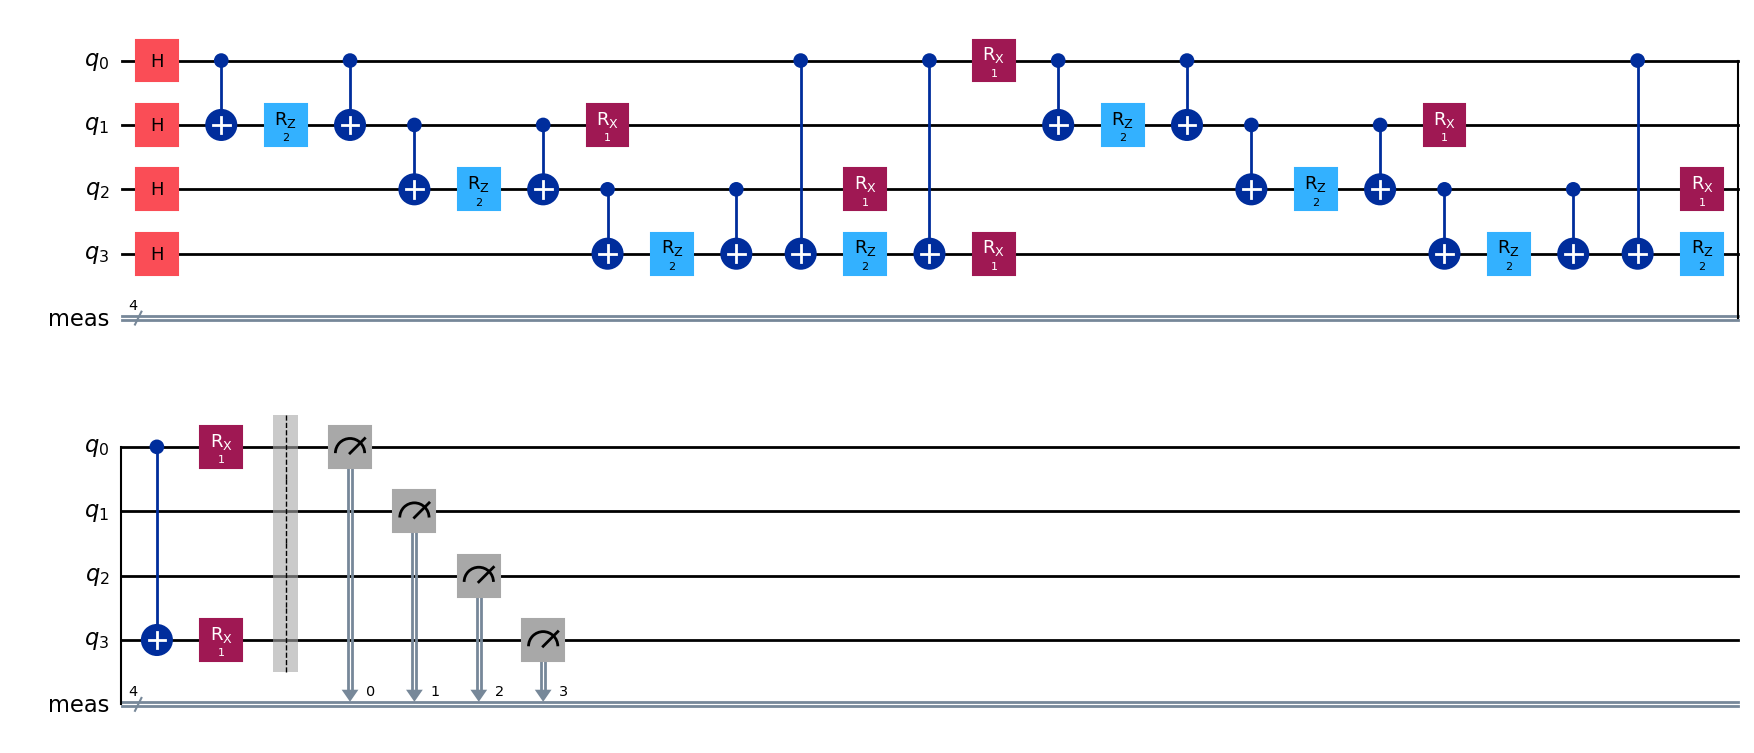

In [3]:
circ.draw("mpl")

In [4]:
# Cargar el circuito desde el archivo QASM 
with open("maxcut.qasm", "r") as f:
    qasm_str = f.read()

# Convertir el QASM a un circuito de Qiskit
circ = qasm3.loads(qasm_str)

# Conectar al servicio de IBM Quantum
service = QiskitRuntimeService(channel="ibm_quantum", token="MI_TOKEN")

# Seleccionar el backend real de IBM Quantum
backend = service.backend("ibm_brisbane")

# Transpilar el circuito 
transpiled_circuit = transpile(circ, backend)

# Crear una instancia de Sampler
sampler = Sampler(mode=backend)

# Ejecutar el circuito con 1024 shots 
job = sampler.run([transpiled_circuit], shots=num_shots)

# Obtener los resultados
result = job.result()

In [5]:
counts = result[0].data.meas.get_counts()
print(counts)

{'1110': 149, '1001': 123, '0011': 315, '0001': 175, '1010': 876, '1100': 174, '0101': 765, '1000': 222, '0010': 184, '1011': 263, '0110': 145, '1111': 122, '1101': 95, '0100': 227, '0000': 116, '0111': 145}


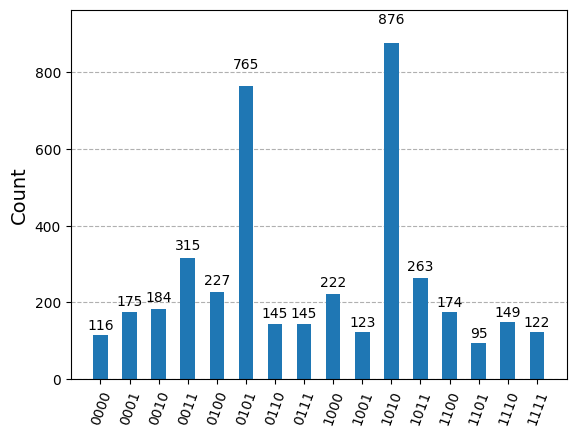

In [17]:
plot_histogram(counts)

In [16]:
# Definir los estados óptimos 
opt_states = ["0101", "1010"] 
opt_value = 4 

# Extraer los tiempos de ejecución desde el resultado
execution_start = result.metadata['execution']['execution_spans'][0].start
execution_end = result.metadata['execution']['execution_spans'][0].stop

# Calcular el tiempo de ejecución real en milisegundos
execution_time = (execution_end - execution_start).total_seconds() * 1000  

# Calcular el tiempo por muestra
t_sample = execution_time / num_shots  

# Obtener los counts del resultado
counts

# Mostrar el histograma de resultados
plot_histogram(counts)

 
# Función para calcular P_GS y TTS
def calculate_P_GS_and_TTS(counts, opt_states, t_sample):
    # Calcular la probabilidad de éxito (P_GS)
    success_counts = sum(counts.get(state, 0) for state in opt_states)
    p_gs = success_counts / num_shots)

    # Calcular el Time to Solution (TTS)
    if p_gs == 0:
        tts = float("inf") 
    else:
        tts = t_sample * np.max([np.ones_like(p_gs), np.abs(np.log(0.01) / np.log(1 - p_gs))], axis=0)

    return p_gs, tts

# Calcular métricas
p_gs, tts = calculate_P_GS_and_TTS(counts, opt_states, t_sample)
print("P_GS (corregido):", p_gs)
print("TTS (corregido):", tts, "ms")

# 🔹 Crear tabla en Jupyter
data = {
    "Instance": ["(4, 4, 0)"],  # Identificador del grafo
    "Opt": [opt_value],         # Valor óptimo
    "P_GS": [p_gs],             # Probabilidad de éxito
    "t_sample (ms)": [t_sample], # Tiempo por muestra
    "TTS (ms)": [tts]           # Tiempo total
}

# Crear el DataFrame
df = pd.DataFrame(data)

# Mostrar la tabla
display(df)

P_GS (corregido): 0.400634765625
TTS (corregido): 4.15032508880361 ms


,Instance,Opt,P_GS,t_sample (ms),TTS (ms)
0,"(4, 4, 0)",4,0.400635,0.461326,4.150325
